## Generate stimulating current

In [137]:
# 1. Import the required libraries
import numpy as np 
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# 2. Load the data from the text file
fp = "./stimuli_April_2023/(lower,upper)=(-100.0, 300)pA/I_Colpitts_x_time_dilation=1.0_(lower,upper)=(-100.0,300)pA.txt"
I_stim_loaded = np.loadtxt(fp)

# Assuming the data is a 1D array, create the time array
timesteps = 0.02 * 1e-3  # Convert to seconds
total_time = 16  # seconds
# time_array = np.arange(0, total_time, timesteps)
time_array = I_stim_loaded[:, 0]

# 3. Create the interpolation function
current_interp = interp1d(time_array, I_stim_loaded[:, 1], kind='cubic', fill_value="extrapolate")

In [138]:
# 4. Define your differential equations

def sig(x, y, z):
    return 0.5 * (1 + np.tanh(0.5 * (y - x) / z))

def diff_eqs(t, y):
    # Extract the current value at time t using the interpolation function
    I_stim = 1e2 * current_interp(t)
    # I_stim = 10
    
    # Define your differential equations here using the `y` vector and the `current` value
    # Replace with your differential equations

    # Constants
    v, h, n, ca, rT = y

    # tauNbar, tauH, taur0, taur1, thrT, ENa, EK, EL, ECa, thetaM, thetaN, thetaH, sigmaM, sigmaN, sigmaH, thetaS, sigmaS, thetaaT, sigmaaT, thetabT, sigmabT, thetarT, sigmarT, sgmrt, phirT, thetaRF, sigmaRF, thetaRS, sigmaRS, kr, ks, Cm, f, eps, kca, gNa, gK, gSK, gCaT, gCaL, gL =\
    #     [1.74629836e+01,  2.19935295e+00,  3.85127752e+01,  1.95114180e+01,
    #     7.10192771e+01,  5.04453947e+01, -9.11302113e+01, -7.43599277e+01,
    #     8.24046063e+01, -3.59998169e+01, -3.59924416e+01, -4.02860804e+01,
    #     -3.05000043e+00, -5.99911928e+00,  4.68343094e+00, -2.32789705e+01,
    #     -1.02493682e+01, -5.98481069e+01, -7.20144121e+00,  5.63526650e-01,
    #     -1.03549368e-02, -6.00645034e+01,  1.98220184e+00,  3.03000001e+00,
    #     1.43803655e+00, -1.06890808e+02,  6.99999990e+00, -9.58811286e+01,
    #     2.99330399e+01,  6.40000000e-01,  6.61458393e-01,  1.00011364e+02,
    #     8.21925055e-02,  2.11899648e-01,  2.45238005e-01,  1.52408435e+03,
    #     3.01365070e+01,  4.47039989e+00,  4.83576881e+00,  1.01927395e+01,
    #     4.82020541e+00]

    # true values
    tauNbar, tauH, taur0, taur1, thrT, ENa, EK, EL, ECa, thetaM, thetaN, thetaH, sigmaM, sigmaN, sigmaH, thetaS, sigmaS, thetaaT, sigmaaT, thetabT, sigmabT, thetarT, sigmarT, sgmrt, phirT, thetaRF, sigmaRF, thetaRS, sigmaRS, kr, ks, Cm, f, eps, kca, gNa, gK, gSK, gCaT, gCaL, gL =\
        [10.0, 1.0, 40.0, 17.5, 68.0, 45.0, -90.0, -70.0, 85.0, -35.0, -30.0, -37.4, -5.0, -5.0, 4.3, -30.0, -12.0, -65.0, -7.8, 0.4, -0.1, -68.0, 2.2, 2.2, 1.0, -105.0, 5.0, -105.0, 25.0, 0.35, 0.35, 100.0, 0.1, 0.0015, 0.3, 450.0, 50.0, 2.0, 3.0, 10.0, 2.0]

    # Na+ and K+ Equations and Currents
    minf = sig(v, thetaM, sigmaM)
    ninf = sig(v, thetaN, sigmaN)
    hinf = sig(v, thetaH, sigmaH)

    tauN = tauNbar / np.cosh(0.5 * (v - thetaN) / sigmaN)

    iNa = gNa * minf**3 * h * (v - ENa)
    iK = gK * n**4 * (v - EK)

    # L-Type Ca++ Equations and Current
    sinf = sig(v, thetaS, sigmaS)
    iCaL = gCaL * sinf**2 * (v - ECa)

    # T-Type Ca++ Equations and Current
    aTinf = sig(v, thetaaT, sigmaaT)
    bTinf = sig(rT, thetabT, sigmabT) - sig(0, thetabT, sigmabT)
    iCaT = gCaT * aTinf**3 * bTinf ** 3 * (v - ECa)

    rTinf = sig(v, thetarT, sigmarT)
    taurT = taur0 + taur1 * sig(v, thrT, sgmrt)

    # SK Equations and Current
    kinf = ca**4 / (ca**4 + ks**4)
    iSK = gSK * kinf * (v - EK)

    # Leak current
    iL = gL * (v - EL)

    # Update du
    dvdt = (-iNa - iK - iCaL - iCaT - iSK - iL + I_stim) / Cm
    # dvdt = I_stim
    dhdt = (hinf - h) / tauH
    dndt = (ninf - n) / tauN
    dCadt = -f * (eps * (iCaL + iCaT) + kca * (ca - 0.1))
    drTdt = phirT * (rTinf - rT) / taurT

    return [dvdt, dhdt, dndt, dCadt, drTdt]
    # return [dvdt, 0, 0, 0, 0]


# 5. Use scipy.integrate.solve_ivp to solve the differential equations over the desired time range
t_span = (2, 13)  # 2 seconds to 13 seconds
initial_conditions = [0.1, 0.1, 0.1, 0.1, 0.1]  # Replace with your initial conditions

sol = solve_ivp(diff_eqs, t_span, initial_conditions, t_eval=np.arange(t_span[0], t_span[1], timesteps), method='LSODA', rtol=1e-7, atol=1e-7)

# Access the results
time_points = sol.t
solution = sol.y

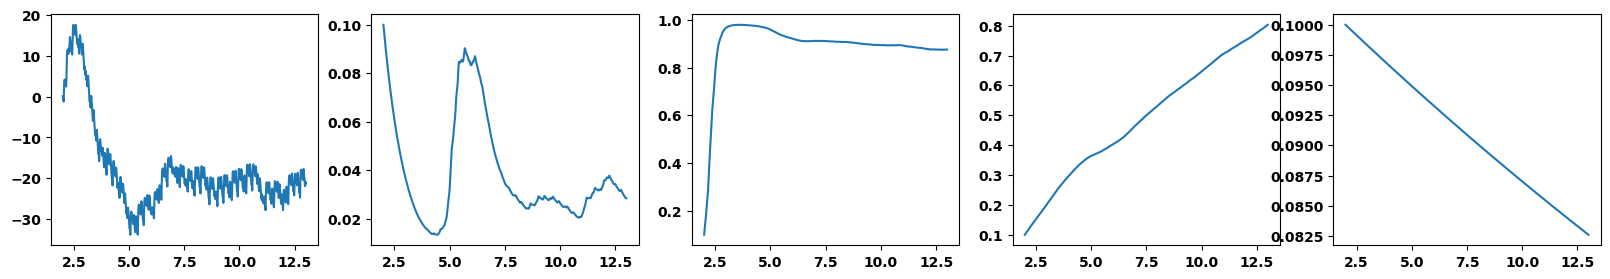

In [139]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,5, figsize=(20, 3))
for i in range(5):
    axes[i].plot(time_points, solution[i, :])

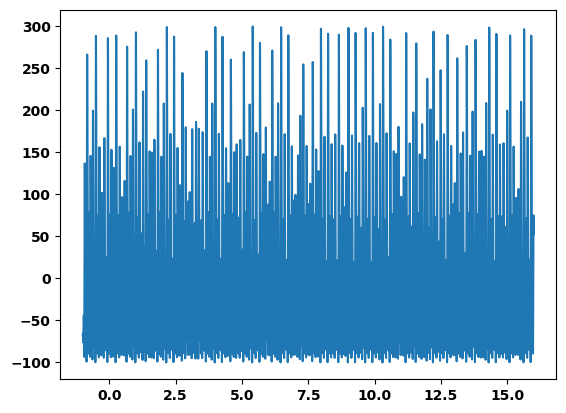

In [140]:
plt.plot(I_stim_loaded[:, 0], I_stim_loaded[:, 1])

In [118]:
np.mean(I_stim_loaded[:,1])

12.516057956929945

In [110]:
import re
filename = "./params.txt"

with open(filename, "r") as file:
    data = file.readlines()

lines = ["".join(d.strip().split('\n')) for d in data]

true_values = []
for line in lines:
    match = re.match(r"(-?\d+(?:\.\d+)?),?\s*(-?\d+(?:\.\d+)?)\s*# (-?\d+(?:\.\d+)?),?\s*(\w+)", line)
    if match:
        true_value, name = float(match.group(3)), match.group(4)
        true_values.append(true_value)

print(true_values)
print("Number of true values detected:", len(true_values))

[10.0, 1.0, 40.0, 17.5, 68.0, 45.0, -90.0, -70.0, 85.0, -35.0, -30.0, -37.4, -5.0, -5.0, 4.3, -30.0, -12.0, -65.0, -7.8, 0.4, -0.1, -68.0, 2.2, 2.2, 1.0, -105.0, 5.0, -105.0, 25.0, 0.35, 0.35, 100.0, 0.1, 0.0015, 0.3, 450.0, 50.0, 2.0, 3.0, 10.0, 2.0]
Number of true values detected: 41
